### 1分足で遊ぶ（バックテスト）

### インポート

In [136]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_finance
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from math import floor
import schedule
import time
import threading
import json
import random
import logging

In [141]:
x = '???????'
logging.warning(df.head())
logging.info('I told you so')

0 2018-07-01 21:20:00+00:00      20  110.720  110.731  110.674  110.674   
1 2018-07-01 21:21:00+00:00       5  110.678  110.679  110.670  110.679   
2 2018-07-01 21:22:00+00:00      51  110.682  110.720  110.678  110.712   
3 2018-07-01 21:23:00+00:00       4  110.720  110.734  110.720  110.734   
4 2018-07-01 21:24:00+00:00     144  110.738  110.842  110.738  110.841   

   BB20,+1  BB20,-1  Lシグナル  Sシグナル  
0  110.680  110.622      0      0  
1  110.677  110.623      1      0  
2  110.678  110.623      1      0  
3  110.684  110.622      1      0  
4  110.693  110.622      1      0  


In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12789646-001"
access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

### 怒濤の関数定義

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
def get_data(count, gran, year, month, day, hour, minute, second):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [116]:
def get_data_super(start, end, gran, sigma):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            df = pd.concat([df, df_tmp], ignore_index=True)
            index = df_tmp.tail(1).index[0]
            s_year = df_tmp.iat[index, 0].year
            s_month = df_tmp.iat[index, 0].month
            s_day = df_tmp.iat[index, 0].day
            s_hour = df_tmp.iat[index, 0].hour
            s_minute = (df_tmp.iat[index, 0].minute + 1) % 60
            s_second = df_tmp.iat[index, 0].second
#             print('{}-{}-{}-{}-{}-{}'.format(s_year, s_month, s_day, s_hour, s_minute, s_second))
            # 5000個ずつ取得してエンド超えたら止める
            if s_year == e_year:
                i = False
        # 止めたらはみ出した分をここで切り落とす
        for i in range(len(df.index) - 5000, len(df.index)):
            if df.iat[i, 0].year == e_year and df.iat[i, 0].month == e_month and df.iat[i, 0].day == e_day:
                df = df[0:i]
                break
    # ボリンジャーバンドを追加
    df['BB20,+{}'.format(sigma)] = df['BB20,-{}'.format(sigma)] = 0
    df['BB20,+{}'.format(sigma)] = df['BB20,+{}'.format(sigma)].apply(float)
    df['BB20,-{}'.format(sigma)] = df['BB20,-{}'.format(sigma)].apply(float)
    for i in range(20, len(df)):
        df.iat[i, 6] = round(mean(df['Close'][i-20:i]) + (np.std(df['Close'][i-20:i]) * sigma), 3)
        df.iat[i, 7] = round(mean(df['Close'][i-20:i]) - (np.std(df['Close'][i-20:i]) * sigma), 3)
    # BB で参照した最初の分を落とす
    df = df[20:]
    df.reset_index(drop=True, inplace=True)
    # シグナル追加
    df['Lシグナル'] = df['Sシグナル'] = 0
    for i in range(len(df)):
        if df.iat[i, 6] < df.iat[i, 5]:
            df.iat[i, 8] = 1
        if df.iat[i, 7] > df.iat[i, 5]:
            df.iat[i, 9] = 1
    return df

In [6]:
def get_evaluation(pos_df):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    WP = round(win_c / len(pos_df.index) * 100, 2)
    print('勝率: {}%'.format(WP))
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    RR = round(win_p / los_p, 4)
    print('ペイオフレシオ: {}'.format(RR))
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = round(P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro, 2)
    print('期待値: {}円'.format(E))
    DD = round(pos_df.sort_values(by='profit', ascending=True).iat[0, 5], 2)
    print('最大ドローダウン: -{}円'.format(DD))
    return WP, RR, E, DD

In [7]:
def set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, df, pos_df, pos_count, lot):
    fee = 0.008
    pos_count+=1
    if pos == 'entry_long':
        pips = (exit_rate - entry_rate - fee) * 100
        l_s = 'long'
    else:
        pips = (entry_rate - exit_rate - fee) * 100
        l_s = 'short'
    profit = lot * 25 * pips / 100
    assets = round(assets + profit, 4)
    tmp_se = pd.Series( [lot, 'long', df.iat[tmp_i,0], entry_rate, df.iat[i+1,0],
                        exit_rate, pips, profit, assets ], index=pos_df.columns )
    pos_df = pos_df.append( tmp_se, ignore_index=True )
    pos = 'None'
    return assets, pos_df, pos_count, pos

### バックテスト

###### BB超えがn個連続したらそっち方向にポジる m分後に決済

In [134]:
# バックテスト
def back_test(df, seed_money, n, m):
    pos = 'None'
    entry_rate = 0
    pos_count = 0
    assets = seed_money
    tmp_i = 9999 # entry_date を記録する用のインデックス
    lot = 1000
    
    pos_df = pd.DataFrame(columns=['lot', 'L or S', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(len(df.index)-1):
        next_rate = df.iat[i+1, 2] # 次の足の始値（エントリー価格）
        tmp_l = 0
        tmp_s = 0
        
        # ポジってから m分経ったら決済
        if i - tmp_i == m:
            exit_rate = next_rate
            assets, pos_df, pos_count, pos = set_profit(tmp_i, i, pos, entry_rate, exit_rate,
                                                        assets, df, pos_df, pos_count, lot)
            if assets < 0:
                break
            
        # Close が BB+σ より n回連続で高ければロング
        for j in range(n):
            tmp_l+=df.iat[i-j, 8] # Lシグナル
        if tmp_l == n:
            # 逆ポジ持ってたら決済
            if pos == 'entry_short':
                exit_rate = next_rate
                assets, pos_df, pos_count, pos = set_profit(tmp_i, i, pos, entry_rate, exit_rate,
                                                            assets, df, pos_df, pos_count, lot)
                if assets < 0:
                    break
            elif pos == 'None':
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i+1
            
        # Close が BB-σ より n回連続で低ければショート
        for j in range(n):
            tmp_s+=df.iat[i-j, 9] # Sシグナル
        if tmp_s == n:
            # 逆ポジ持ってたら決済
            if pos == 'entry_long':
                exit_rate = next_rate
                assets, pos_df, pos_count, pos = set_profit(tmp_i, i, pos, entry_rate, exit_rate,
                                                            assets, df, pos_df, pos_count, lot)
                if assets < 0:
                    break
            elif pos == 'None':
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i+1
                    
    print('n: {}, m: {}, posision count: {}, seed_money: {}万円, assets: {}万円'.format(n, m, pos_count,
                                                                                    seed_money/10000, round(assets/10000, 4)))
#     return pos_count, round(assets/10000, 4), pos_df
    return pos_df

In [135]:
# df = get_data_super(start='2018-07-01-00-00-00', end='2019-01-01-00-00-00', gran='M1', sigma=1)
for n in [2,4,6,8,10]:
    for m in [5,10,15,20]:
        pos_df = back_test(df=df, seed_money=10000000, n=n, m=m)

n: 2, m: 5, posision count: 18767, seed_money: 1000.0万円, assets: 596.9275万円
n: 2, m: 10, posision count: 13057, seed_money: 1000.0万円, assets: 717.8525万円
n: 2, m: 15, posision count: 10638, seed_money: 1000.0万円, assets: 765.9975万円
n: 2, m: 20, posision count: 9277, seed_money: 1000.0万円, assets: 798.475万円
n: 4, m: 5, posision count: 12258, seed_money: 1000.0万円, assets: 730.87万円
n: 4, m: 10, posision count: 9153, seed_money: 1000.0万円, assets: 797.3925万円
n: 4, m: 15, posision count: 7821, seed_money: 1000.0万円, assets: 837.425万円
n: 4, m: 20, posision count: 7140, seed_money: 1000.0万円, assets: 842.8525万円
n: 6, m: 5, posision count: 8129, seed_money: 1000.0万円, assets: 824.2525万円
n: 6, m: 10, posision count: 6327, seed_money: 1000.0万円, assets: 861.1625万円
n: 6, m: 15, posision count: 5703, seed_money: 1000.0万円, assets: 878.17万円
n: 6, m: 20, posision count: 5279, seed_money: 1000.0万円, assets: 883.6525万円
n: 8, m: 5, posision count: 5414, seed_money: 1000.0万円, assets: 880.885万円
n: 8, m: 10, posisi

### グラフ

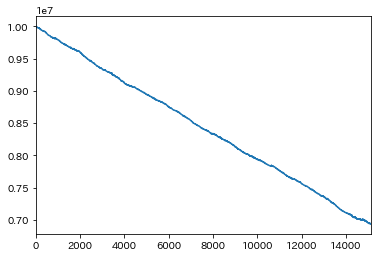

In [128]:
pos_df['assets'].plot()

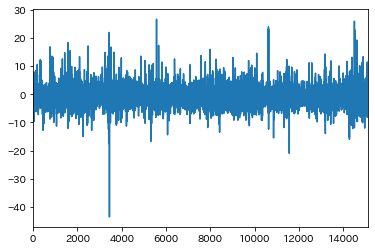

In [129]:
pos_df['pips'].plot()

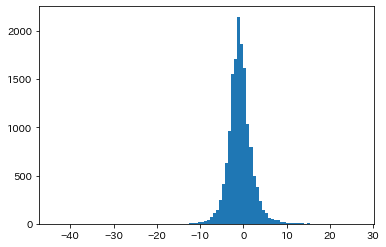

In [130]:
plt.hist(pos_df['pips'], bins=100)
plt.show()

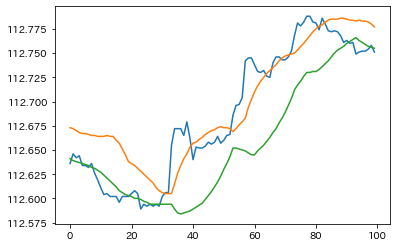

In [31]:
# i = random.randint(0, len(df))
i = 0
fig, ax = plt.subplots()
ax.plot(df['Close'][i:i+100])
ax.plot(df['BB20,+1'][i:i+100])
ax.plot(df['BB20,-1'][i:i+100])
plt.show()

### チェック

In [437]:
pos_df.head()

,lot,L or S,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,10,long,2013-01-02 01:21:00+00:00,86.857,2013-01-02 01:41:00+00:00,86.909,4.4,11.00,10000011.00
1,10,long,2013-01-02 01:41:00+00:00,86.909,2013-01-02 02:01:00+00:00,86.948,3.1,7.75,10000018.75
2,10,long,2013-01-02 02:01:00+00:00,86.948,2013-01-02 02:21:00+00:00,86.936,-2.0,-5.00,10000013.75
3,10,long,2013-01-02 02:21:00+00:00,86.936,2013-01-02 02:41:00+00:00,87.062,11.8,29.50,10000043.25
4,10,long,2013-01-02 02:41:00+00:00,87.062,2013-01-02 03:01:00+00:00,87.166,9.6,24.00,10000067.25


In [438]:
df.head()

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル
0,2013-01-02 01:20:00+00:00,15,86.853,86.860,86.853,86.857,86.853,86.803,1,0
1,2013-01-02 01:21:00+00:00,30,86.857,86.857,86.850,86.854,86.855,86.809,1,0
2,2013-01-02 01:22:00+00:00,32,86.854,86.869,86.854,86.869,86.856,86.809,1,0
3,2013-01-02 01:23:00+00:00,39,86.871,86.882,86.871,86.880,86.860,86.812,1,0
4,2013-01-02 01:24:00+00:00,26,86.881,86.890,86.880,86.888,86.864,86.814,1,0


In [429]:
pos_df.sort_values(by='pips').head()

,lot,L or S,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
2666,10,long,2013-02-25 20:18:00+00:00,92.481,2013-02-25 20:38:00+00:00,91.186,-130.3,-325.75,9993474.00
4546,10,short,2013-04-04 04:39:00+00:00,92.911,2013-04-04 04:59:00+00:00,94.092,-118.9,-297.25,9988328.50
3637,10,long,2013-03-15 20:46:00+00:00,95.264,2013-03-17 21:05:00+00:00,94.248,-102.4,-256.00,9990702.25
8294,10,short,2013-06-19 17:56:00+00:00,95.218,2013-06-19 18:16:00+00:00,96.154,-94.4,-236.00,9980927.50
7670,10,long,2013-06-06 16:19:00+00:00,97.305,2013-06-06 16:39:00+00:00,96.396,-91.7,-229.25,9982219.50


In [384]:
# シグナル点灯のタイミングをチェック
df['Lシグナル'] = df['Sシグナル'] = 0
for i in range(len(df)):
    if df.iat[i, 6] < df.iat[i, 3]:
        df.iat[i, 8] = 1
    if df.iat[i, 7] > df.iat[i, 4]:
        df.iat[i, 9] = 1

In [395]:
i = 513
df[i:i+20]

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル
513,2013-01-02 09:54:00+00:00,30,87.096,87.106,87.088,87.095,87.102,87.075,1,0
514,2013-01-02 09:55:00+00:00,12,87.098,87.098,87.090,87.092,87.102,87.078,0,0
515,2013-01-02 09:56:00+00:00,28,87.094,87.098,87.090,87.096,87.103,87.078,0,0
516,2013-01-02 09:57:00+00:00,18,87.096,87.096,87.090,87.094,87.103,87.078,0,0
517,2013-01-02 09:58:00+00:00,15,87.094,87.099,87.094,87.098,87.103,87.079,0,0
518,2013-01-02 09:59:00+00:00,15,87.098,87.100,87.093,87.093,87.103,87.079,0,0
519,2013-01-02 10:00:00+00:00,45,87.090,87.100,87.087,87.090,87.102,87.079,0,0
520,2013-01-02 10:01:00+00:00,75,87.088,87.102,87.074,87.076,87.100,87.079,1,1
521,2013-01-02 10:02:00+00:00,30,87.077,87.080,87.070,87.080,87.097,87.078,0,1
522,2013-01-02 10:03:00+00:00,5,87.080,87.080,87.078,87.079,87.095,87.077,0,0


In [393]:
df.shape

(371427, 10)

### 1年間で検証

In [308]:
p_s_n = pd.DataFrame(columns=['period', 'sigma', 'n', 'pos_count', 'assets', '勝率', 'ペイオフレシオ',
                              'ケリー基準', '期待値', '最大ドローダウン'])
for p in range(10, 18+1):
    period = '20{}'.format(p)
    start = '20{}-01-01-00-00-00'.format(p)
    end = '20{}-01-01-00-00-00'.format(p+1)
    for s in range(1, 5+1):
        df = get_data_super(start=start, end=end, gran='M1', sigma=s)
        for n in range(10, 35+1):
            pos_count, assets, pos_df = back_test(df=df, seed_money=10000000, n=n)
            WP, RR, KLY, E, DD = get_evaluation(pos_df)
            print('period: {}, sigma: {}, n: {}, pos_count: {}, assets: {}万円'.format(period, s, n, pos_count, assets))
            tmp_se = pd.Series([period, s, n, pos_count, assets, WP, RR, KLY, E, DD], index=p_s_n.columns)
            p_s_n = p_s_n.append(tmp_se, ignore_index=True)

period: 2010, sigma: 1, n: 10, pos_count: 62241, assets: 5480.375万円
period: 2010, sigma: 1, n: 11, pos_count: 57792, assets: 5831.8425万円
period: 2010, sigma: 1, n: 12, pos_count: 54243, assets: 6230.78万円
period: 2010, sigma: 1, n: 13, pos_count: 51174, assets: 6453.9425万円
period: 2010, sigma: 1, n: 14, pos_count: 48429, assets: 6653.405万円
period: 2010, sigma: 1, n: 15, pos_count: 46045, assets: 6866.37万円
period: 2010, sigma: 1, n: 16, pos_count: 43916, assets: 7043.8125万円
period: 2010, sigma: 1, n: 17, pos_count: 41955, assets: 7135.2075万円
period: 2010, sigma: 1, n: 18, pos_count: 40185, assets: 7221.92万円
period: 2010, sigma: 1, n: 19, pos_count: 38534, assets: 7264.7875万円
period: 2010, sigma: 1, n: 20, pos_count: 37063, assets: 7173.1875万円
period: 2010, sigma: 1, n: 21, pos_count: 35808, assets: 7032.485万円
period: 2010, sigma: 1, n: 22, pos_count: 34659, assets: 6841.945万円
period: 2010, sigma: 1, n: 23, pos_count: 33599, assets: 6624.1275万円
period: 2010, sigma: 1, n: 24, pos_count: 32

period: 2010, sigma: 5, n: 28, pos_count: 4026, assets: 1052.41万円
period: 2010, sigma: 5, n: 29, pos_count: 4006, assets: 1064.93万円
period: 2010, sigma: 5, n: 30, pos_count: 3989, assets: 1082.86万円
period: 2010, sigma: 5, n: 31, pos_count: 3971, assets: 1087.805万円
period: 2010, sigma: 5, n: 32, pos_count: 3957, assets: 1087.19万円
period: 2010, sigma: 5, n: 33, pos_count: 3946, assets: 1103.2775万円
period: 2010, sigma: 5, n: 34, pos_count: 3935, assets: 1123.045万円
period: 2010, sigma: 5, n: 35, pos_count: 3914, assets: 1129.2725万円
period: 2011, sigma: 1, n: 10, pos_count: 58966, assets: 3317.8275万円
period: 2011, sigma: 1, n: 11, pos_count: 54852, assets: 3670.2475万円
period: 2011, sigma: 1, n: 12, pos_count: 51459, assets: 3991.4525万円
period: 2011, sigma: 1, n: 13, pos_count: 48473, assets: 4243.0225万円
period: 2011, sigma: 1, n: 14, pos_count: 45901, assets: 4426.035万円
period: 2011, sigma: 1, n: 15, pos_count: 43693, assets: 4622.4425万円
period: 2011, sigma: 1, n: 16, pos_count: 41694, asse

period: 2011, sigma: 5, n: 20, pos_count: 4150, assets: 830.765万円
period: 2011, sigma: 5, n: 21, pos_count: 4138, assets: 811.725万円
period: 2011, sigma: 5, n: 22, pos_count: 4115, assets: 808.3775万円
period: 2011, sigma: 5, n: 23, pos_count: 4102, assets: 840.8875万円
period: 2011, sigma: 5, n: 24, pos_count: 4082, assets: 853.74万円
period: 2011, sigma: 5, n: 25, pos_count: 4072, assets: 847.115万円
period: 2011, sigma: 5, n: 26, pos_count: 4057, assets: 839.1575万円
period: 2011, sigma: 5, n: 27, pos_count: 4038, assets: 847.8275万円
period: 2011, sigma: 5, n: 28, pos_count: 4020, assets: 855.5875万円
period: 2011, sigma: 5, n: 29, pos_count: 3991, assets: 883.045万円
period: 2011, sigma: 5, n: 30, pos_count: 3971, assets: 904.9775万円
period: 2011, sigma: 5, n: 31, pos_count: 3946, assets: 910.4825万円
period: 2011, sigma: 5, n: 32, pos_count: 3917, assets: 901.3225万円
period: 2011, sigma: 5, n: 33, pos_count: 3899, assets: 943.0275万円
period: 2011, sigma: 5, n: 34, pos_count: 3886, assets: 952.8825万円
p

period: 2012, sigma: 5, n: 12, pos_count: 3674, assets: 837.9475万円
period: 2012, sigma: 5, n: 13, pos_count: 3670, assets: 843.29万円
period: 2012, sigma: 5, n: 14, pos_count: 3666, assets: 856.1125万円
period: 2012, sigma: 5, n: 15, pos_count: 3663, assets: 858.915万円
period: 2012, sigma: 5, n: 16, pos_count: 3659, assets: 874.535万円
period: 2012, sigma: 5, n: 17, pos_count: 3653, assets: 870.6325万円
period: 2012, sigma: 5, n: 18, pos_count: 3647, assets: 894.585万円
period: 2012, sigma: 5, n: 19, pos_count: 3639, assets: 891.2825万円
period: 2012, sigma: 5, n: 20, pos_count: 3623, assets: 904.2775万円
period: 2012, sigma: 5, n: 21, pos_count: 3608, assets: 912.3525万円
period: 2012, sigma: 5, n: 22, pos_count: 3590, assets: 909.12万円
period: 2012, sigma: 5, n: 23, pos_count: 3582, assets: 916.325万円
period: 2012, sigma: 5, n: 24, pos_count: 3562, assets: 912.5775万円
period: 2012, sigma: 5, n: 25, pos_count: 3540, assets: 908.7425万円
period: 2012, sigma: 5, n: 26, pos_count: 3529, assets: 913.56万円
perio

period: 2013, sigma: 4, n: 30, pos_count: 9587, assets: 1205.94万円
period: 2013, sigma: 4, n: 31, pos_count: 9469, assets: 1225.465万円
period: 2013, sigma: 4, n: 32, pos_count: 9364, assets: 1255.6325万円
period: 2013, sigma: 4, n: 33, pos_count: 9263, assets: 1310.0425万円
period: 2013, sigma: 4, n: 34, pos_count: 9166, assets: 1316.3925万円
period: 2013, sigma: 4, n: 35, pos_count: 9067, assets: 1346.3275万円
period: 2013, sigma: 5, n: 10, pos_count: 5270, assets: 736.065万円
period: 2013, sigma: 5, n: 11, pos_count: 5269, assets: 742.915万円
period: 2013, sigma: 5, n: 12, pos_count: 5248, assets: 703.055万円
period: 2013, sigma: 5, n: 13, pos_count: 5233, assets: 678.4225万円
period: 2013, sigma: 5, n: 14, pos_count: 5224, assets: 727.535万円
period: 2013, sigma: 5, n: 15, pos_count: 5218, assets: 746.765万円
period: 2013, sigma: 5, n: 16, pos_count: 5210, assets: 751.24万円
period: 2013, sigma: 5, n: 17, pos_count: 5192, assets: 769.3575万円
period: 2013, sigma: 5, n: 18, pos_count: 5179, assets: 785.85万円
p

KeyboardInterrupt: 